# Experiment 5

This experiment is similar to experiment 4 in that it works with a single particle (x and y coordinate), but instead of predicting only one frame in the future, we will try to predict mutiple frames in the future.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

# import functions
import sys
sys.path.insert(0, '../')
from my_functions import *

from sklearn import preprocessing

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

## Read data

In [20]:
data = pd.read_csv('../../data/processed/trajectories.csv')

In [21]:
# the particle we are trying to predict
particle = 0

coordinate_df = data[data['particle'] == particle].reset_index(drop=True)
coordinate_df.head()

,y,x,frame,particle
0,24.420047,61.809992,0.0,0.0
1,22.786106,70.800099,1.0,0.0
2,23.797221,78.538462,2.0,0.0
3,22.500377,92.436819,3.0,0.0
4,22.045133,104.597821,4.0,0.0


In [22]:
# scale the data x and y separately as they have very different ranges
min_max_scaler_x = preprocessing.MinMaxScaler()
min_max_scaler_y = preprocessing.MinMaxScaler()

data_scaled = coordinate_df.copy()
data_scaled['x'] = min_max_scaler_x.fit_transform(np.reshape(coordinate_df['x'].values.astype(float), (-1, 1)))
data_scaled['y'] = min_max_scaler_y.fit_transform(np.reshape(coordinate_df['y'].values.astype(float), (-1, 1)))

**Particles used for training**


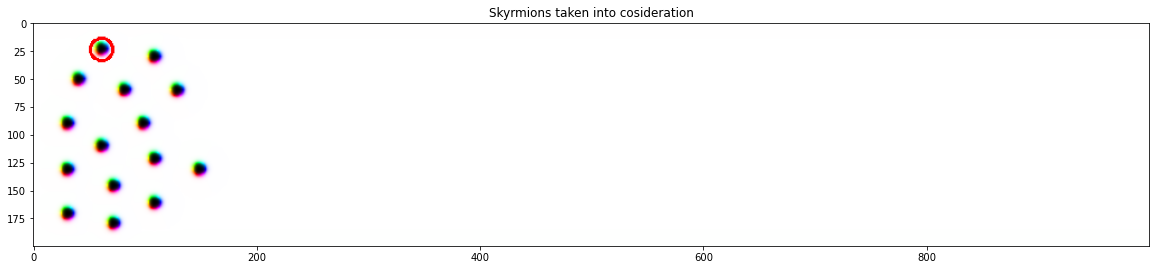

Getting frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 1190.12it/s]


In [23]:
# show which frames we will be working on
print('**Particles used for training**')
show_tracked(coordinate_df, '../../data/raw')

frames = np.array(get_frames(data_scaled))

In [24]:
# split into train and test sets
train_size = int(len(frames) * 0.67)
test_size = len(frames) - train_size
train, test = frames[0:train_size,:], frames[train_size:len(frames),:]
print(f'Train length: {len(train)}')
print(f'Test length: {len(test)}')

Train length: 536
Test length: 264


In [42]:
# choose a number of time steps
n_steps_in, n_steps_out = 1, 2

# convert into input/output
X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

## Define the model and train

In [43]:
# define model
def create_model():
    model = Sequential()
    
    model.add(SimpleRNN(32, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(Dense(64))
    model.add(Dense(2 * n_steps_out))
    
    model.compile(optimizer='adam', loss='mae')
    
    return model

In [44]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = '../../models/rnn_5/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    period=5)

In [45]:
# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
history = model.fit(
    X_train, 
    y_train,
    epochs=250,
    callbacks=[cp_callback],
    validation_data=(X_test,y_test))

Train on 534 samples, validate on 262 samples
Epoch 1/250
534/534 [==============================] - 0s 354us/step - loss: 0.3046 - val_loss: 0.3939
Epoch 2/250
534/534 [==============================] - 0s 52us/step - loss: 0.1002 - val_loss: 0.1168
Epoch 3/250
534/534 [==============================] - 0s 50us/step - loss: 0.0614 - val_loss: 0.0981
Epoch 4/250
534/534 [==============================] - 0s 47us/step - loss: 0.0331 - val_loss: 0.0298
Epoch 5/250
534/534 [==============================] - 0s 49us/step - loss: 0.0208 - val_loss: 0.0224
Epoch 6/250
534/534 [==============================] - 0s 52us/step - loss: 0.0145 - val_loss: 0.0173
Epoch 7/250
534/534 [==============================] - 0s 47us/step - loss: 0.0123 - val_loss: 0.0178
Epoch 8/250
534/534 [==============================] - 0s 45us/step - loss: 0.0110 - val_loss: 0.0144
Epoch 9/250
534/534 [==============================] - 0s 45us/step - loss: 0.0110 - val_loss: 0.0154
Epoch 10/250
534/534 [=============

## Evaluate

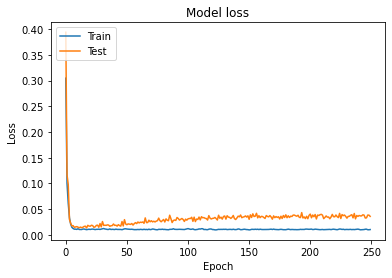

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [49]:
print('The model performance for X_train')
pred_train = evaluate(X_train, y_train, model)
print('The model performance for X_test')
pred_test = evaluate(X_test, y_test, model)

The model performance for X_train
--------------------------------------
RMSE is 0.016382759153750762
R2 score is 0.9899218053623053


The model performance for X_test
--------------------------------------
RMSE is 0.05028926893404424
R2 score is 0.5067592936226533




In [50]:
pred_train = pred_train.reshape(pred_train.shape[0], -1, 2)
pred_test = pred_test.reshape(pred_test.shape[0], -1, 2)

In [51]:
pred_train_unscaled = pred_train.copy()
pred_test_unscaled = pred_test.copy()

for i in range(len(pred_train_unscaled)):
    pred_train_unscaled[i, :, 0] = min_max_scaler_x.inverse_transform(np.reshape(pred_train_unscaled[i, :, 0].astype(float), (1, -1)))
    pred_train_unscaled[i, :, 1] = min_max_scaler_y.inverse_transform(np.reshape(pred_train_unscaled[i, :, 1].astype(float), (1, -1)))
    
for i in range(len(pred_test_unscaled)):
    pred_test_unscaled[i, :, 0] = min_max_scaler_x.inverse_transform(np.reshape(pred_test_unscaled[i, :, 0].astype(float), (1, -1)))
    pred_test_unscaled[i, :, 1] = min_max_scaler_y.inverse_transform(np.reshape(pred_test_unscaled[i, :, 1].astype(float), (1, -1)))

In [52]:
X_train_unscaled = X_train.copy()
X_test_unscaled = X_test.copy()

for i in range(len(X_train_unscaled)):
    X_train_unscaled[i, :, 0] = min_max_scaler_x.inverse_transform(np.reshape(X_train_unscaled[i, :, 0].astype(float), (1, -1)))
    X_train_unscaled[i, :, 1] = min_max_scaler_y.inverse_transform(np.reshape(X_train_unscaled[i, :, 1].astype(float), (1, -1)))
    
for i in range(len(X_test_unscaled)):
    X_test_unscaled[i, :, 0] = min_max_scaler_x.inverse_transform(np.reshape(X_test_unscaled[i, :, 0].astype(float), (1, -1)))
    X_test_unscaled[i, :, 1] = min_max_scaler_y.inverse_transform(np.reshape(X_test_unscaled[i, :, 1].astype(float), (1, -1)))

In [53]:
start = 0
# to avoid printing too many plots
limit = min(len(X_train_unscaled), 5 * (n_steps_in+n_steps_out))

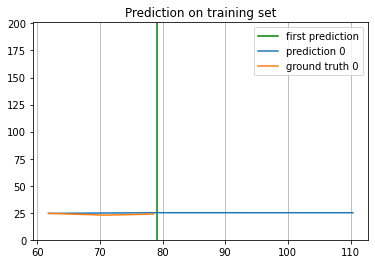

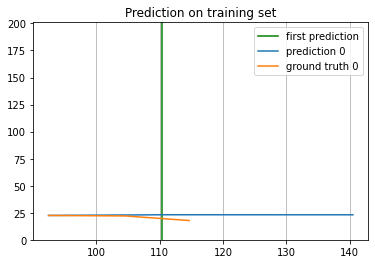

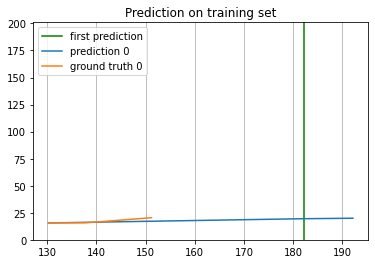

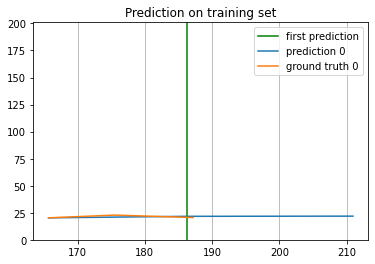

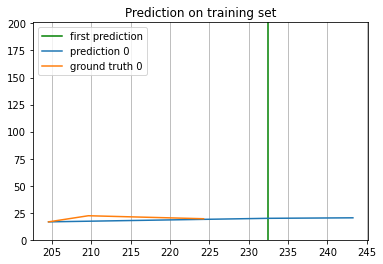

In [59]:
for i in range (start, start+limit, n_steps_in + n_steps_out):
    plt.figure()
    plt.grid(True, axis='x')
    plt.ylim(0, 201)
    plt.title('Prediction on training set')

    plt.axvline(x=pred_train_unscaled[i, 0, 0], ymin=0, ymax=1, label='first prediction', color='g')
    x = np.concatenate((X_train_unscaled[i, :, 0], pred_train_unscaled[i, : , 0]))
    y = np.concatenate((X_train_unscaled[i, :, 1], pred_train_unscaled[i, : , 1]))

    plt.plot(x, y, label='prediction ' + str(particle), color='tab:blue')
    plt.plot(data[data['particle'] == particle]['x'][i:i+n_steps_in+n_steps_out], data[data['particle'] == particle]['y'][i:i+n_steps_in+n_steps_out], label='ground truth ' + str(particle), color='tab:orange')

    plt.legend()

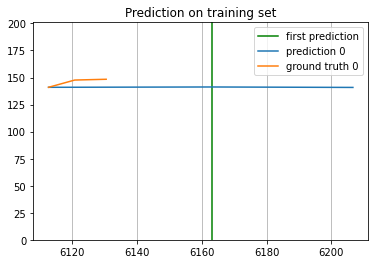

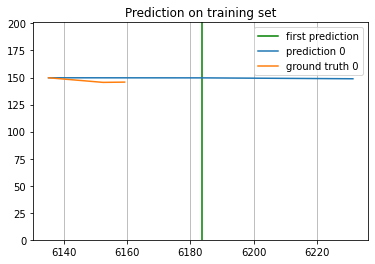

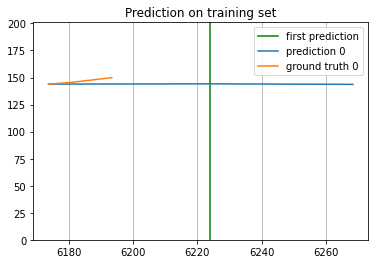

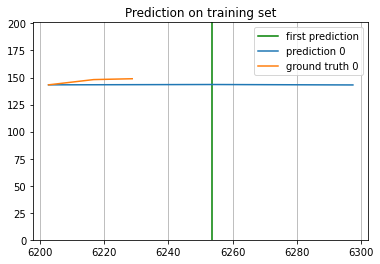

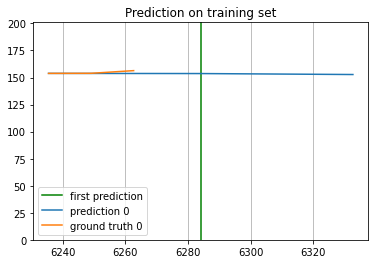

In [57]:
for i in range (start, start+limit, n_steps_in + n_steps_out):
    plt.figure()
    plt.grid(True, axis='x')
    plt.ylim(0, 201)
    plt.title('Prediction on training set')

    plt.axvline(x=pred_test_unscaled[i, 0, 0], ymin=0, ymax=1, label='first prediction', color='g')
    x = np.concatenate((X_test_unscaled[i, :, 0], pred_test_unscaled[i, : , 0]))
    y = np.concatenate((X_test_unscaled[i, :, 1], pred_test_unscaled[i, : , 1]))

    plt.plot(x, y, label='prediction ' + str(particle), color='tab:blue')
    plt.plot(data[data['particle'] == particle]['x'][train_size+i:train_size+i+n_steps_in+n_steps_out], data[data['particle'] == particle]['y'][train_size+i:train_size+i+n_steps_in+n_steps_out], label='ground truth ' + str(particle), color='tab:orange')

    plt.legend()